In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

npix = hp.nside2npix(32)

%matplotlib inline

In [33]:
def is_in_oct4(pix):
    nside = 4
    x,y,z = hp.pix2vec(nside,pix)
    return (x>0)&(y>0)&(z<0)

def remove_boundaries(pix_vals,nside):
    '''remove boundaries from mask in case you find boundary issues'''
    neighbs = hp.pixelfunc.get_all_neighbours(nside,pix_vals)
    bools = np.ones(len(pix_vals))==1
    for i in range(8):
        bools *= np.array(list(map(is_in_oct4,neighbs[i])))
    inner_vals = pix_vals[bools]
    mask_inner = np.isin(np.arange(hp.nside2npix(nside)),inner_vals)
    return  mask_inner, inner_vals

def create_mask(nside):
    xx,yy,zz = hp.pix2vec(nside,np.arange(hp.nside2npix(nside)))
    oct_mask= (xx>0)&(yy>0)&(zz<0)
    pix_vals = np.arange(hp.nside2npix(nside))[oct_mask]
    return oct_mask,pix_vals

def compute_std(inner_vals,s1_vals,s2_vals):
    s1_var=np.zeros((len(inner_vals),29))
    s2_var=np.zeros((len(inner_vals),29))
    for i in range(len(inner_vals)):
        s1a = [s1_vals[j][inner_vals[i]] for j in range(29)]
        s2a = [s2_vals[j][inner_vals[i]] for j in range(29)]
        s1_var[i] = s1a; s2_var[i]=s2a;
    std_1 = np.std(s1_var,0)
    std_2 = np.std(s2_var,0)
    return std_1,std_2

def compute_vals(inner_vals,s1_vals,s2_vals,i):
    s1a = [s1_vals[j][inner_vals[i]] for j in range(29)]
    s2a = [s2_vals[j][inner_vals[i]] for j in range(29)]
    return s1a,s2a




## maps
I have created some downgraded (value averaged over pixel) maps at nside 32. This really just gives us an easy way of looking at the position-dependent average values and the variance in the quantities. Let's first of all read these in and just take a look at a couple. There doesn't appear to be much of an obvious position-dependent bias which is reassuring.  

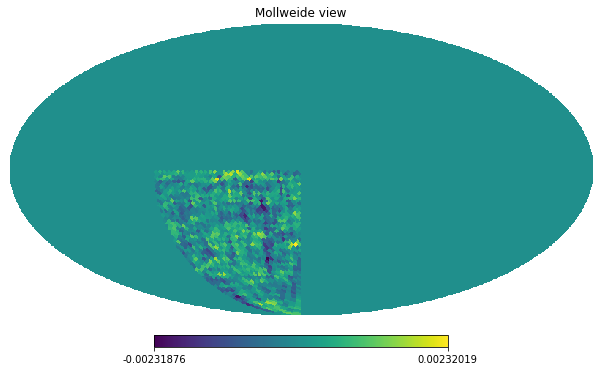

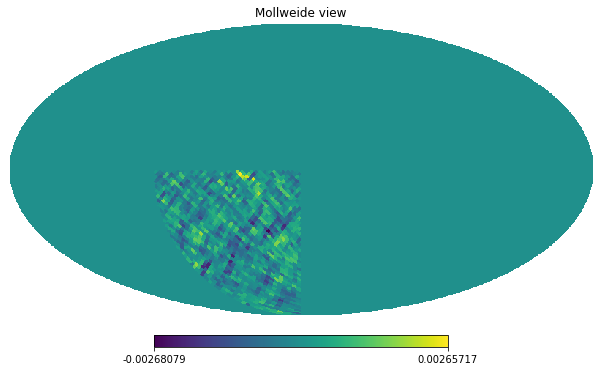

In [16]:
s1_vals={}; s2_vals={}
for i in range(29):
    ''' reading in downgraded lensing maps'''
    s1_vals[i] = hp.read_map('s1_'+str(i)+'.fits');
    s2_vals[i] = hp.read_map('s2_'+str(i)+'.fits');

z = np.loadtxt('inps/z_or_skysim.txt')[:29]

oct_mask,pix_vals = create_mask(32);

hp.mollview(s1_vals[10]*oct_mask)
hp.mollview(s2_vals[10]*oct_mask)
plt.show()

### Average values as a function of z
Now we have these read in, let's look at the quantity of interest, the average value as a function of redshift. Note that values increasing as a function of redshift is expected.. this is simply the lensing kernel responding to some feature that's not being averaged out entirely. Note that fractional errors would also increase as the shear values are increasing with redshift. 

Notably I don't see any particular difference between shear_1 and shear_2 that extends beyond simply different features in the sky. Certainly no factor of 10 differences. 

/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 32
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


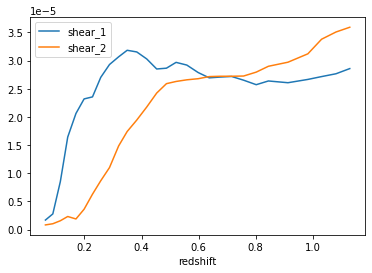

In [14]:

# full mean values of s1/s2
s1_seq=[]; s2_seq=[]
for i in range(29):
    s1_seq.append(np.mean(s1_vals[i][oct_mask]))
    s2_seq.append(np.mean(s2_vals[i][oct_mask]))
s1_seq = np.array(s1_seq); s2_seq = np.array(s2_seq)

plt.figure()
plt.plot(z[:29],s1_seq,label='shear_1')
plt.plot(z[:29],-s2_seq, label='shear_2') # negative just to compare levels
plt.legend()
plt.xlabel('redshift')
plt.show()


Now let's compute the standard deviation from the different pixels, to see what the variance really looks like in a more quantitative way. I get the below plot showing that they're very very consistent when averaged over the octant. 

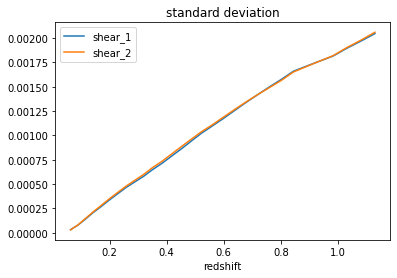

In [13]:
std1, std2 = compute_std(pix_vals,s1_vals,s2_vals)
plt.figure()
plt.title('standard deviation')
plt.plot(z,std1,label='shear_1')
plt.plot(z,std2,label='shear_2')
plt.legend()
plt.xlabel('redshift')
plt.show()

Finally what does this look like for the areas in question? Well ~400 square degrees is roughly about 2 pixels at nside =4, so let's downgrade further to nside=4 in the maps and see what it looks like.

In [25]:
s1_vals2={}; s2_vals2={}
for i in range(29):
    ''' further downgrading lensing maps'''
    s1_vals2[i] = hp.ud_grade(s1_vals[i],nside_out=4)
    s2_vals2[i] = hp.ud_grade(s2_vals[i],nside_out=4)
    



/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/pixelfunc.py:690: RuntimeWarning: divide by zero encountered in _pix2vec_ring
  return pixlib._pix2vec_ring(nside, ipix)
/home/tricia/miniconda3/lib/python3.8/site-packages/healpy/pixelfunc.py:690: RuntimeWarning: invalid value encountered in _pix2vec_ring
  return pixlib._pix2vec_ring(nside, ipix)


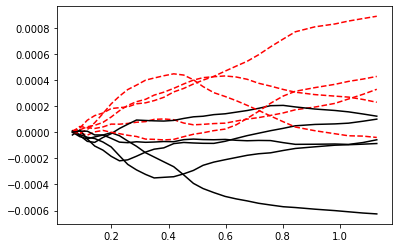

In [35]:
oct_mask2,pix_vals2 = create_mask(4);
cut_mask2,inner_vals2= remove_boundaries(pix_vals2,4)
# cutting boundaries as pixels with only half the area containing values are going to cause problems 

plt.figure()
for i in range(len(inner_vals2)):
    s1a, s2a = compute_vals(inner_vals2,s1_vals2,s2_vals2,i)
    plt.plot(z,s1a,'r--')
    plt.plot(z,s2a,'k')
plt.show()




For these pixels one of these happens to be more positive and one more negative.. so we check more widely to see if this is the case generally and we see it isn't the case (which we already saw on the octant map). 

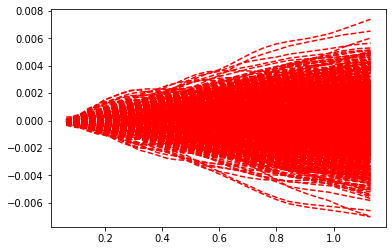

In [37]:
plt.figure()
for i in range(len(pix_vals)):
    s1a, s2a = compute_vals(pix_vals,s1_vals,s2_vals,i)
    plt.plot(z,s1a,'r--')
    #plt.plot(z,s2a,'k')
plt.show()


Finally let's add error bars to the earlier plot, remembering as we do that these are highly correlated errors. If there is a filament affecting one redshift it *will* affect the next redshift, as these are not just numerical errors.

In [ ]:
plt.figure()
plt.errorbar(z[:29],s1_seq,std1/np.sqrt(),label='shear_1')
plt.errorbar(z[:29],s2_seq,std2/np.sqrt(), label='shear_2') # number here is the number of pixels
plt.legend()
plt.xlabel('redshift')
plt.show()
